In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [2]:
from functools import partial
import jax
import jax.numpy as jnp
import typer
from jax import jit

from bpd import DATA_DIR
from bpd.io import load_dataset
from bpd.pipelines import pipeline_shear_inference_simple


import matplotlib.pyplot as plt 

In [3]:
# fpath_plus = "/pscratch/sd/i/imendoza/data/cache_chains/exp40_42/interim_samples_42_plus.npz"
# fpath_minus = "/pscratch/sd/i/imendoza/data/cache_chains/exp40_42/interim_samples_42_minus.npz"

In [4]:
fpath_plus = "/pscratch/sd/i/imendoza/data/cache_chains/exp45_42/interim_samples_42_plus.npz"
fpath_minus = "/pscratch/sd/i/imendoza/data/cache_chains/exp45_42/interim_samples_42_minus.npz"

In [5]:
samples_plus = load_dataset(fpath_plus)
samples_minus = load_dataset(fpath_minus)

In [6]:
samples_plus.keys()

dict_keys(['e_post', 'e1_true', 'e2_true', 'f', 'true_g', 'sigma_e', 'sigma_e_int', 'mean_logflux', 'sigma_logflux'])

In [34]:
e_post_plus = samples_plus["e_post"][:100]
e_post_minus = samples_minus["e_post"][:100]
true_g = samples_plus["true_g"]
assert jnp.all(true_g == - samples_minus['true_g'])
sigma_e = samples_plus["sigma_e"]
sigma_e_int = samples_plus["sigma_e_int"]

assert jnp.all(samples_plus["e1_true"] == samples_minus["e1_true"])
assert jnp.all(samples_plus["f"] == samples_minus["f"])

e_post_plus.shape, e_post_minus.shape

((100, 300, 2), (100, 300, 2))

In [35]:
seed = 42
rng_key = jax.random.key(seed)

In [54]:
raw_pipeline = partial(
    pipeline_shear_inference_simple,
    sigma_e=sigma_e,
    sigma_e_int=sigma_e_int,
    n_samples=40000,
    initial_step_size=1e-3,
    max_num_doublings=2
)
pipe = jit(raw_pipeline)


In [55]:
# jit
_ = pipe(rng_key, e_post_plus[:2, :, :], true_g)

In [56]:
g_samples_plus = pipe(rng_key, e_post_plus, init_g=jnp.array([0.,0.]))

In [57]:
g_samples_minus = pipe(rng_key, e_post_minus, init_g=jnp.array([0.,0.]))

In [58]:
g_samples_plus.shape, g_samples_minus.shape

((40000, 2), (40000, 2))

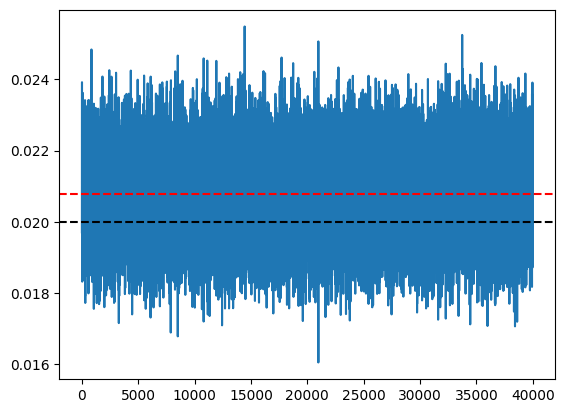

In [59]:
g1p = g_samples_plus[:, 0]

plt.plot(g1p)
plt.axhline(g1p.mean(), color='r', linestyle='--')
plt.axhline(0.02, color='k', linestyle='--')

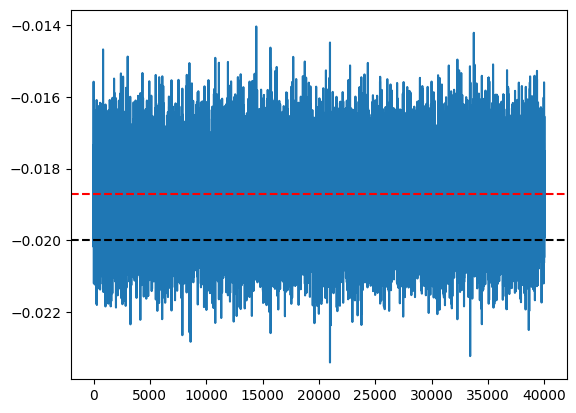

In [60]:
g1m = g_samples_minus[:, 0]

plt.plot(g1m)
plt.axhline(g1m.mean(), color='r', linestyle='--')
plt.axhline(-0.02, color='k', linestyle='--')

In [52]:
g1m.shape

(20000,)

In [53]:
abs(g1p.mean().item() - 0.02), abs(g1m.mean().item() + 0.02)

(0.0007882589986648973, 0.00128313381339136)

In [64]:
g1p.mean() - abs(g1m.mean())


Array(0.00204505, dtype=float64)

In [68]:
g1p.std() / jnp.sqrt(40000)

Array(5.34149758e-06, dtype=float64)